### K-Means

This notebook explores the patterns of medication adherence by analyzing event intervals between prescriptions. The primary objective is to identify distinct clusters of patients based on their medication refill behavior using the Sessa Empirical Estimator method, which uses KMeans clustering, Empirical Cumulative Distribution Function (ECDF), and Silhouette Score Analysis.

The dataset used in this analysis comes from AdhereR's med.events dataset, which contains records of prescription dates, medication types, and daily doses. The key challenge is to determine whether patients exhibit distinct medication adherence patterns based on their prescription refill intervals.

#### Key steps include:

- Data preprocessing and transformation
- ECDF (Empirical Cumulative Distribution Function) computation
- Kernel Density Estimation (KDE)
- Silhouette Analysis for optimal cluster selection
- K-Means clustering and cluster assignment

#### Key Steps in the Analysis

Data Preprocessing:

- The dataset is loaded from AdhereR in R and converted to a pandas DataFrame.
- Prescription refill intervals (time between consecutive prescriptions) are calculated.


#### ECDF and 80th Percentile Filtering:

- The Empirical Cumulative Distribution Function (ECDF) is computed to identify the 80th percentile of refill intervals.
- This threshold is used to filter out extreme values that might represent irregular behavior.


#### Density Estimation and Data Transformation:

- The log-transformed event intervals are analyzed using Gaussian Kernel Density Estimation (KDE) to visualize distribution patterns.

#### KMeans Clustering and Silhouette Score Optimization:

- Silhouette Analysis is used to determine the most optimal number of clusters k for KMeans.
- KMeans clustering is performed on the ECDF x values (event intervals)


#### Cluster Assignment and Final Data Processing:

- The most common cluster is identified, and a default median event interval is assigned to unclustered patients.
- The results are merged back into the original dataset for further analysis.

#### Assumption Checking with Boxplots:

- The duration between prescription refills is visualized using boxplots to check for assumptions regarding patient adherence.

### Import Required Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# rpy2 (for AdhereR)
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

### Load Dataset using AdhereR's med.events

In [13]:
pandas2ri.activate()
robjects.r('library(AdhereR)')
med_events_r = robjects.r('med.events')
med_events = pandas2ri.rpy2py(med_events_r)

# Convert and rename columns
ExamplePats = med_events.copy()
tidy = ExamplePats.copy()
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

### Patient Sampling Function

In [14]:
def patient_sampling(drug_see):
    drug_see_p1 = drug_see.sort_values(['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd']).copy()
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=1234))
                   .reset_index(drop=True))
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)
    return drug_see_p1

### ECDF Computation

In [15]:
def ecdf_computation(drug_see):
    ecdf_see = ECDF(drug_see['event.interval'].values)
    x_vals = np.sort(drug_see['event.interval'].values)
    y_vals = ecdf_see(x_vals)

    df_ecdf = pd.DataFrame({'x': x_vals, 'y': y_vals})
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()

    return df_ecdf_80, df_ecdf, ni

### ECDF Plotting

In [16]:
def plot_ecdf(df_ecdf_80, df_ecdf):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(df_ecdf_80['x'], df_ecdf_80['y'], marker='.', linestyle='none')
    axs[0].set_title("80% ECDF")
    axs[0].set_xlabel("Event Interval")
    axs[0].set_ylabel("ECDF")

    axs[1].plot(df_ecdf['x'], df_ecdf['y'], marker='.', linestyle='none')
    axs[1].set_title("100% ECDF")
    axs[1].set_xlabel("Event Interval")
    axs[1].set_ylabel("ECDF")
    plt.show()

### Kernel Density Estimation

In [17]:
def density_estimation(drug_see):
    log_intervals = np.log(drug_see['event.interval'])
    kde = gaussian_kde(log_intervals)
    x_grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_kde = kde(x_grid)

    return x_grid, y_kde

### Silhouette Analysis for Optimal Clusters

In [18]:
def silhouette_analysis(kde_scaled):
    silhouette_scores = {}
    for k in range(2, min(11, len(kde_scaled))):
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(kde_scaled)
        score = silhouette_score(kde_scaled, labels)
        silhouette_scores[k] = score
    optimal_k = max(silhouette_scores, key=silhouette_scores.get) if silhouette_scores else 1
    return silhouette_scores, optimal_k

### K-Means Clustering

In [19]:
def kmeans(optimal_k, df_ecdf):
    km_ecdf = KMeans(n_clusters=optimal_k, random_state=1234)
    df_ecdf['cluster'] = km_ecdf.fit_predict(df_ecdf[['x']])

### Cluster Assignment

In [20]:
def cluster_assignment(df_ecdf, drug_see_p0, drug_see_p1):
    cluster_stats = (df_ecdf.groupby('cluster')['x']
                     .agg(min_log=lambda x: np.log(x).min(),
                          max_log=lambda x: np.log(x).max(),
                          median_log=lambda x: np.log(x).median())
                     .reset_index())

    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])

    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]

    drug_see_p1['_key'] = 1
    cluster_stats['_key'] = 1
    cross_df = pd.merge(drug_see_p1, cluster_stats, on='_key').drop('_key', axis=1)

    cross_df['Final_cluster'] = cross_df.apply(
        lambda row: row['cluster'] if (row['event.interval'] >= row['Minimum'] and row['event.interval'] <= row['Maximum'])
        else np.nan, axis=1)
    
    results = cross_df.dropna(subset=['Final_cluster']).copy()
    results = results[['pnr', 'Median', 'Final_cluster']]

    most_common_cluster = results['Final_cluster'].value_counts().idxmax()
    default_median = cluster_stats.loc[cluster_stats['cluster'] == most_common_cluster, 'Median'].values[0]

    drug_see_p1 = pd.merge(drug_see_p1, results, on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(default_median)
    drug_see_p1['Cluster'] = drug_see_p1['Final_cluster'].fillna(0)

    final_df = pd.merge(drug_see_p0, drug_see_p1[['pnr', 'Median', 'Cluster']], on='pnr', how='left')
    final_df['Median'] = final_df['Median'].fillna(default_median)
    final_df['Cluster'] = final_df['Cluster'].fillna(0)

    return final_df

### Run the Analysis

In [21]:
def See(arg1):
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = C09CA01.copy()
    drug_see_p1 = patient_sampling(C09CA01)

    df_ecdf_80, df_ecdf, ni = ecdf_computation(drug_see_p1)
    plot_ecdf(df_ecdf_80, df_ecdf)

    x_grid, y_kde = density_estimation(drug_see_p1)
    
    kde_df = pd.DataFrame({'x': x_grid, 'y': y_kde})
    scaler = StandardScaler()
    kde_scaled = scaler.fit_transform(kde_df)

    silhouette_scores, optimal_k = silhouette_analysis(kde_scaled)

    kmeans(optimal_k, df_ecdf)
    final_df = cluster_assignment(df_ecdf, drug_see_p0, drug_see_p1)

    return final_df

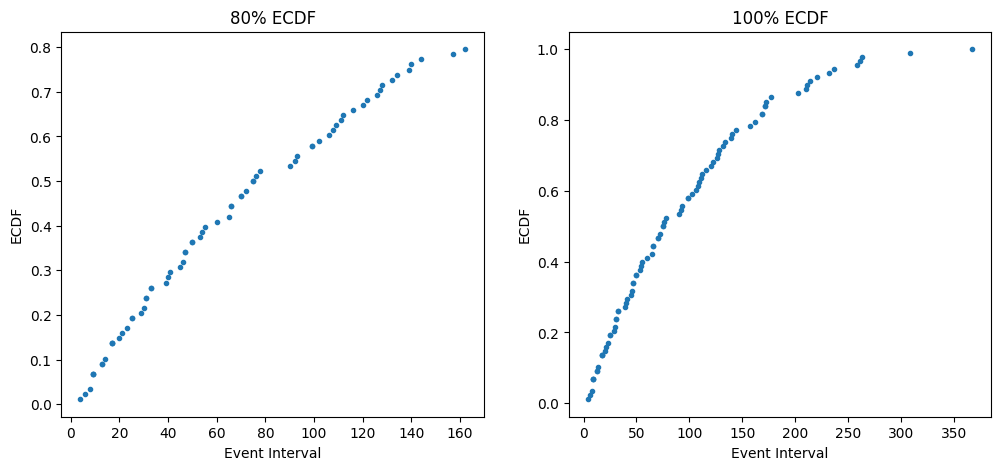

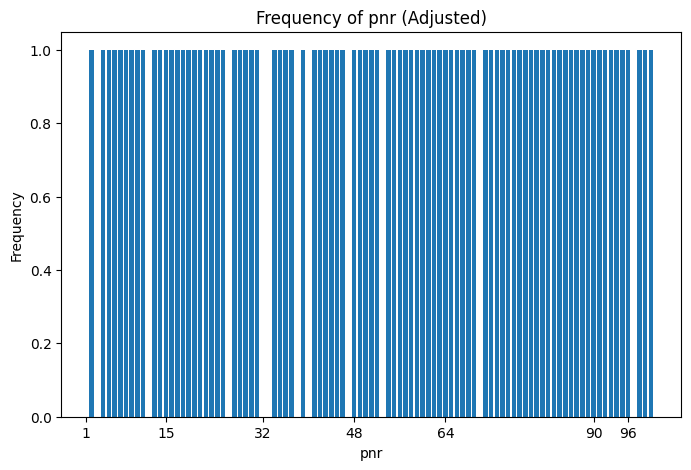

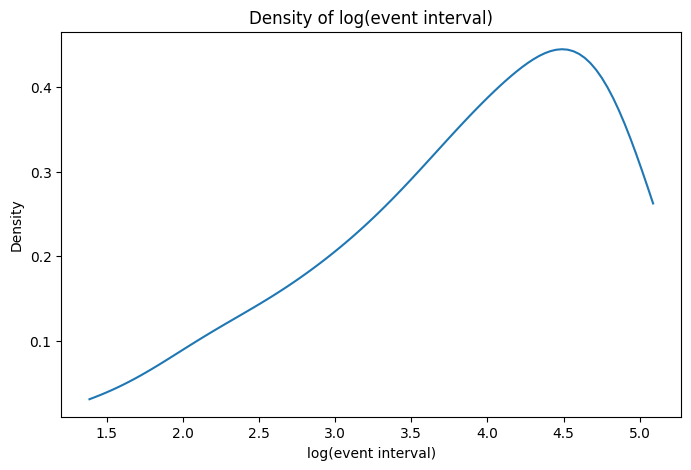

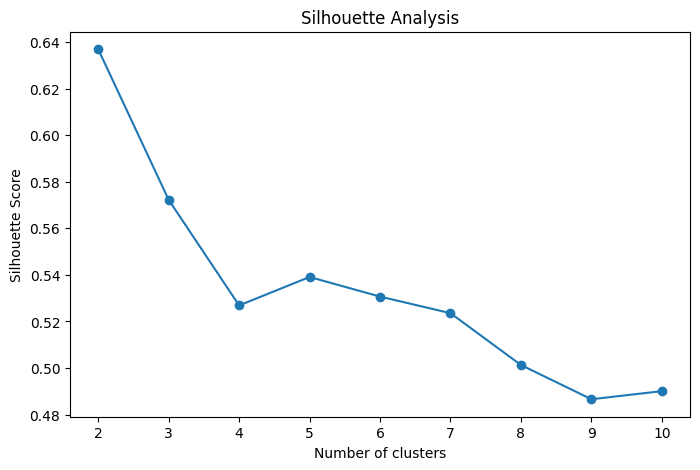

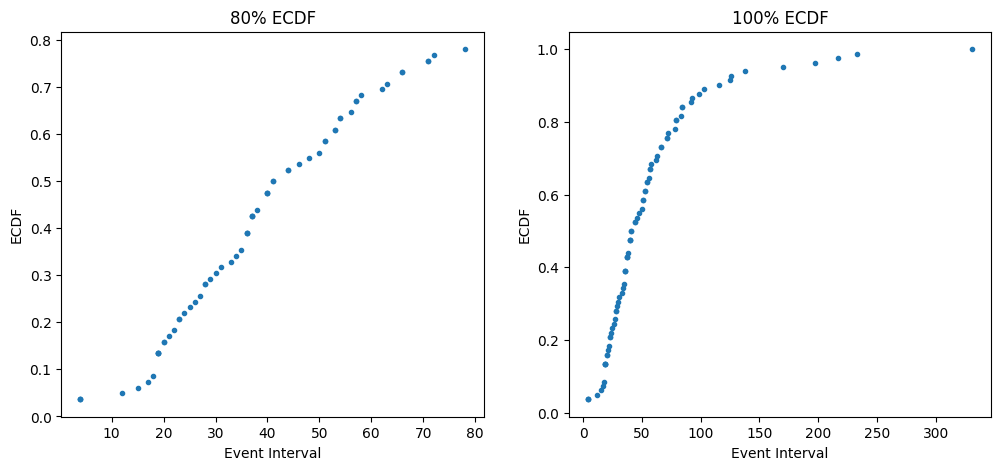

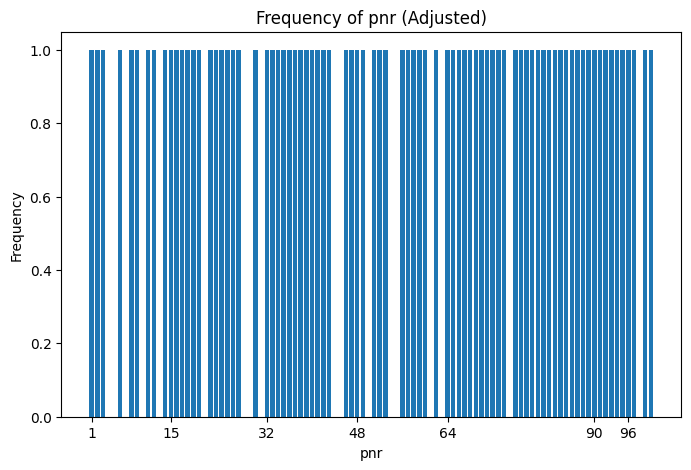

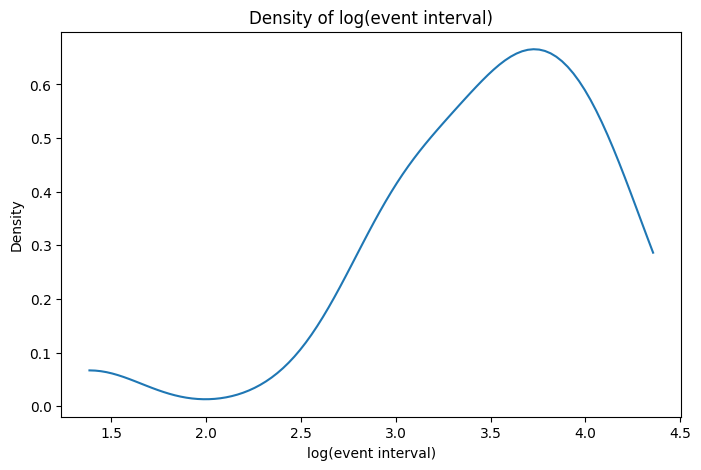

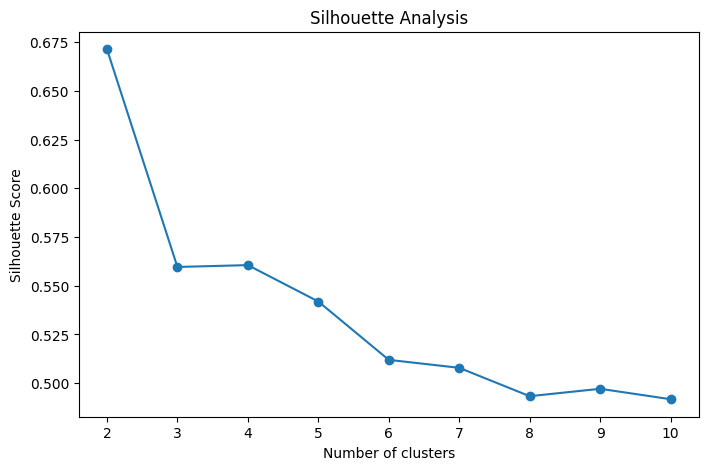

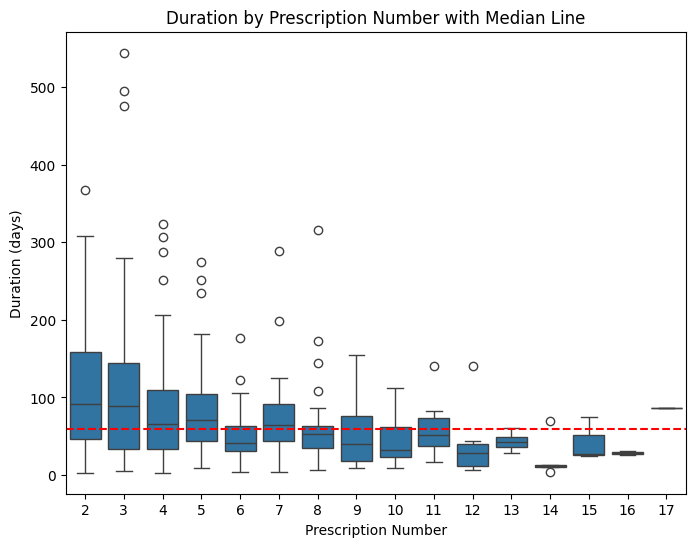

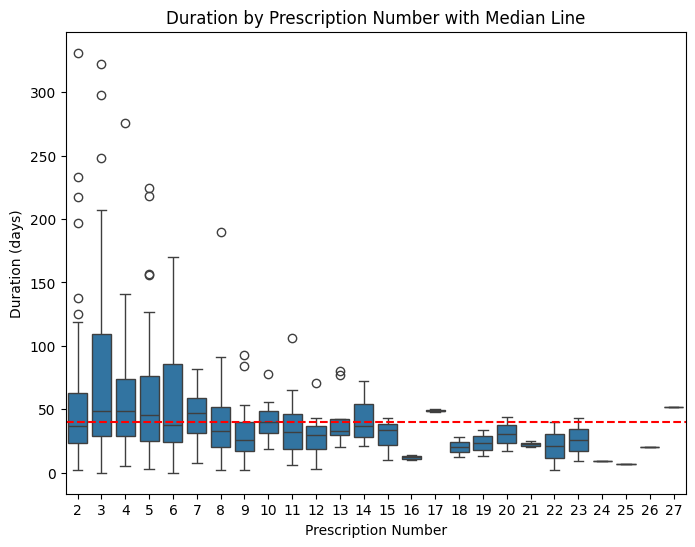

In [22]:
%run SEE_KMeans_Sep.py
medA = See("medA")
medB = See("medB")

see_assumption(medA)
see_assumption(medB)